## Test Large-Sample Mushroom Performance

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score
import pandas as pd
from bart_playground.bart import DefaultBART, LogisticBART

In [2]:
# Parameters
N_TREES = 50
NDPOST = 500
NSKIP = 0
RANDOM_STATE = 42

# If debug then run with only one dataset and record running time
# Otherwise run with all datasets
debug = False
np.random.seed(RANDOM_STATE)

In [3]:
from mushroom import load_mushroom

# Load datasets
def load_datasets():
    X_mushroom, y_mushroom = load_mushroom()
    # X_mr_encoded, y_mr_encoded = load_mushroom_encoded()
    
    return {
        "Mushroom": (X_mushroom, y_mushroom),
        # "Mushroom Encoded": (X_mr_encoded, y_mr_encoded)
    }

## Dataset Loading

In [4]:
old_settings = np.seterr(invalid='raise')

datasets = load_datasets()

In [5]:
for name, (X, y) in datasets.items():
    # Print dataset shapes
    print(f"Dataset: {name}\nX shape: {X.shape}, y shape: {y.shape}")
    # Print 0-1 distribution of y
    print(f"y distribution: {pd.Series(y.flatten()).value_counts(normalize=True).to_dict()}")

Dataset: Mushroom
X shape: (8000, 22), y shape: (8000, 1)
y distribution: {0: 0.5175, 1: 0.4825}


## Experiments

In [6]:
ini_bart = DefaultBART(n_trees=N_TREES, ndpost=10, nskip=1, random_state=RANDOM_STATE)
ini_bart.fit(X, y)
ini_bart.predict(X)

ini_bart = LogisticBART(n_trees=N_TREES, ndpost=10, nskip=1, random_state=RANDOM_STATE)
ini_bart.fit(X.astype(float), y)
ini_bart.predict(X)

Iterations: 100%|██████████| 11/11 [00:01<00:00, 10.81it/s]


array([0, 1, 1, ..., 1, 1, 1])

In [7]:
def record_evaluation_results(X, y, BARTClass=DefaultBART):
    
    # Initialize BART model
    bart = BARTClass(n_trees=N_TREES, ndpost=NDPOST, nskip=NSKIP, random_state=RANDOM_STATE)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    # Fit the model
    bart.fit(X_train, y_train)

    # Predict probabilities
    y_pred_prob = np.clip(bart.predict(X_test), 1e-15, 1 - 1e-15)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calculate metrics
    logloss = log_loss(y_test, y_pred_prob)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"Log Loss: {logloss:.4f}, Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")
    
    return bart, X_test, y_test 

In [10]:
bart, X_test, y_test = record_evaluation_results(X, y, DefaultBART)

Iterations:   0%|          | 0/500 [00:00<?, ?it/s]

Iterations: 100%|██████████| 500/500 [00:08<00:00, 56.72it/s]


Log Loss: 0.0048, Accuracy: 1.0000, ROC AUC: 1.0000


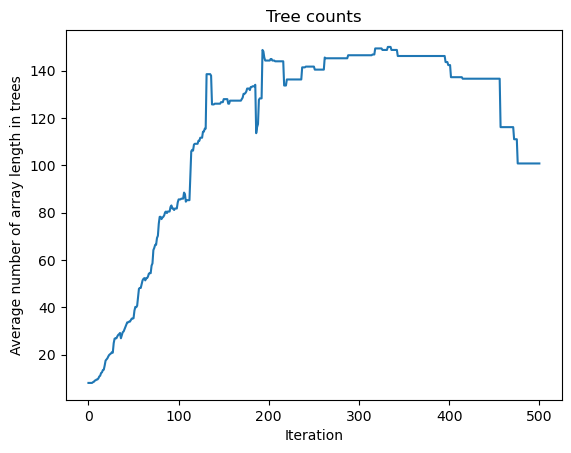

In [11]:
# plot
tree_counts = []
for i in range(len(bart.trace)):
    tree_counts.append(np.mean([len(arr) for arr in [tree.vars for tree in bart.trace[i].trees]]))
import matplotlib.pyplot as plt
plt.plot(tree_counts)
plt.title(f"Tree counts")
plt.xlabel("Iteration")
plt.ylabel("Average number of array length in trees")
plt.show()

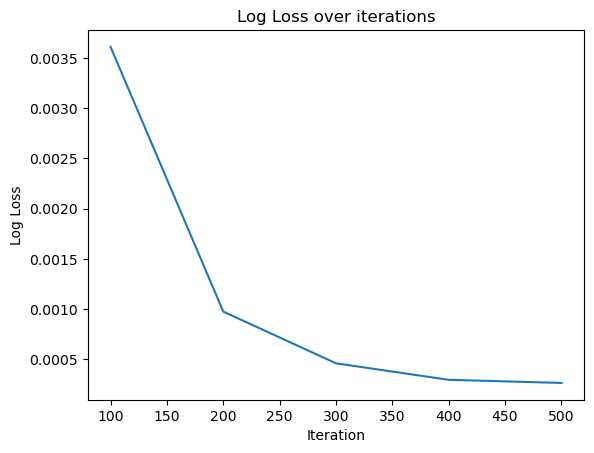

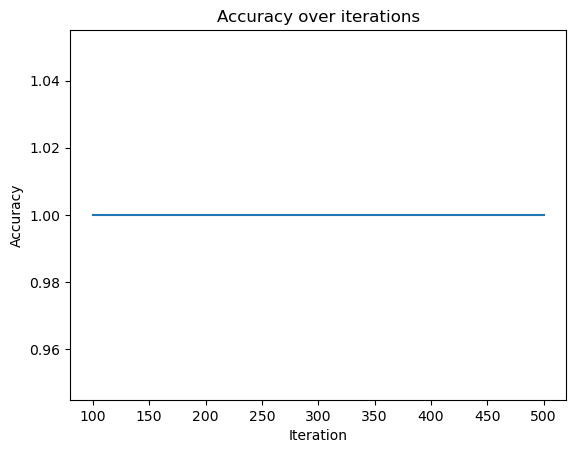

In [12]:
logloss_arr = []
acc_arr = []
its = []
for i in range(len(bart.trace)):
    if i>0 and i % 100 == 0:
        preds = np.zeros((X_test.shape[0], 50))
        for k in range(i-50, i):
            y_eval = bart.trace[k].evaluate(X_test)
            preds[:, k - (i-50)] = bart.preprocessor.backtransform_y(y_eval)
        mean_pred = np.mean(preds, axis=1)
    
        y_pred_prob = np.clip(mean_pred, 1e-15, 1 - 1e-15)
        logloss = log_loss(y_test, y_pred_prob)
        logloss_arr.append(logloss)
        y_pred = (y_pred_prob > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        acc_arr.append(accuracy)
        its.append(i)
        
plt.plot(its, logloss_arr)
plt.title(f"Log Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.show()
plt.plot(its, acc_arr)
plt.title(f"Accuracy over iterations")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()